# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


# Preprocessing
Feature engineering, create categorial columns

In [63]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': bool, 'Promo': bool, 'SchoolHoliday': bool})

# FEATURE ENGINEERING
## month
df_train['Year'] = pd.DatetimeIndex(df_train['Date']).to_period('Y')

df_train.info()
df_train.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  bool          
 6   Promo          1017209 non-null  bool          
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  bool          
 9   Year           1017209 non-null  period[A-DEC] 
dtypes: bool(3), datetime64[ns](1), int64(4), object(1), period[A-DEC](1)
memory usage: 57.2+ MB


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year
0,1,5,2015-07-31,5263,555,True,True,0,True,2015
1,2,5,2015-07-31,6064,625,True,True,0,True,2015
2,3,5,2015-07-31,8314,821,True,True,0,True,2015
3,4,5,2015-07-31,13995,1498,True,True,0,True,2015
4,5,5,2015-07-31,4822,559,True,True,0,True,2015


# Per store analysis
In the following analysis per ONE store id is done and data prepared to be able to forecast sales for one store

## Seasonality
A time series is periodic if it repeats itself at equally spaced intervals, say, every 12 months, every 1 week, every 4 months, and so on.
Let us check if our time series has some seasonality element to it.

If yes, we can forecast entire weeks or months

/tmp/ipykernel_69700/1575430016.py:25: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_weekly_sum['Week'] = df_weekly_sum.index.week


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Week,Sales_per_open_days_avg
Date,,,,,,,,,,
2013-01-06,12,18,23317,2741,4,0,3,2013,1,5829
2013-01-13,18,21,51567,4940,6,5,0,2013,2,8594
2013-01-20,18,21,28225,3615,6,0,0,2013,3,4704
2013-01-27,18,21,41215,4267,6,5,0,2013,4,6869
2013-02-03,18,21,33209,4137,6,0,0,2013,5,5534


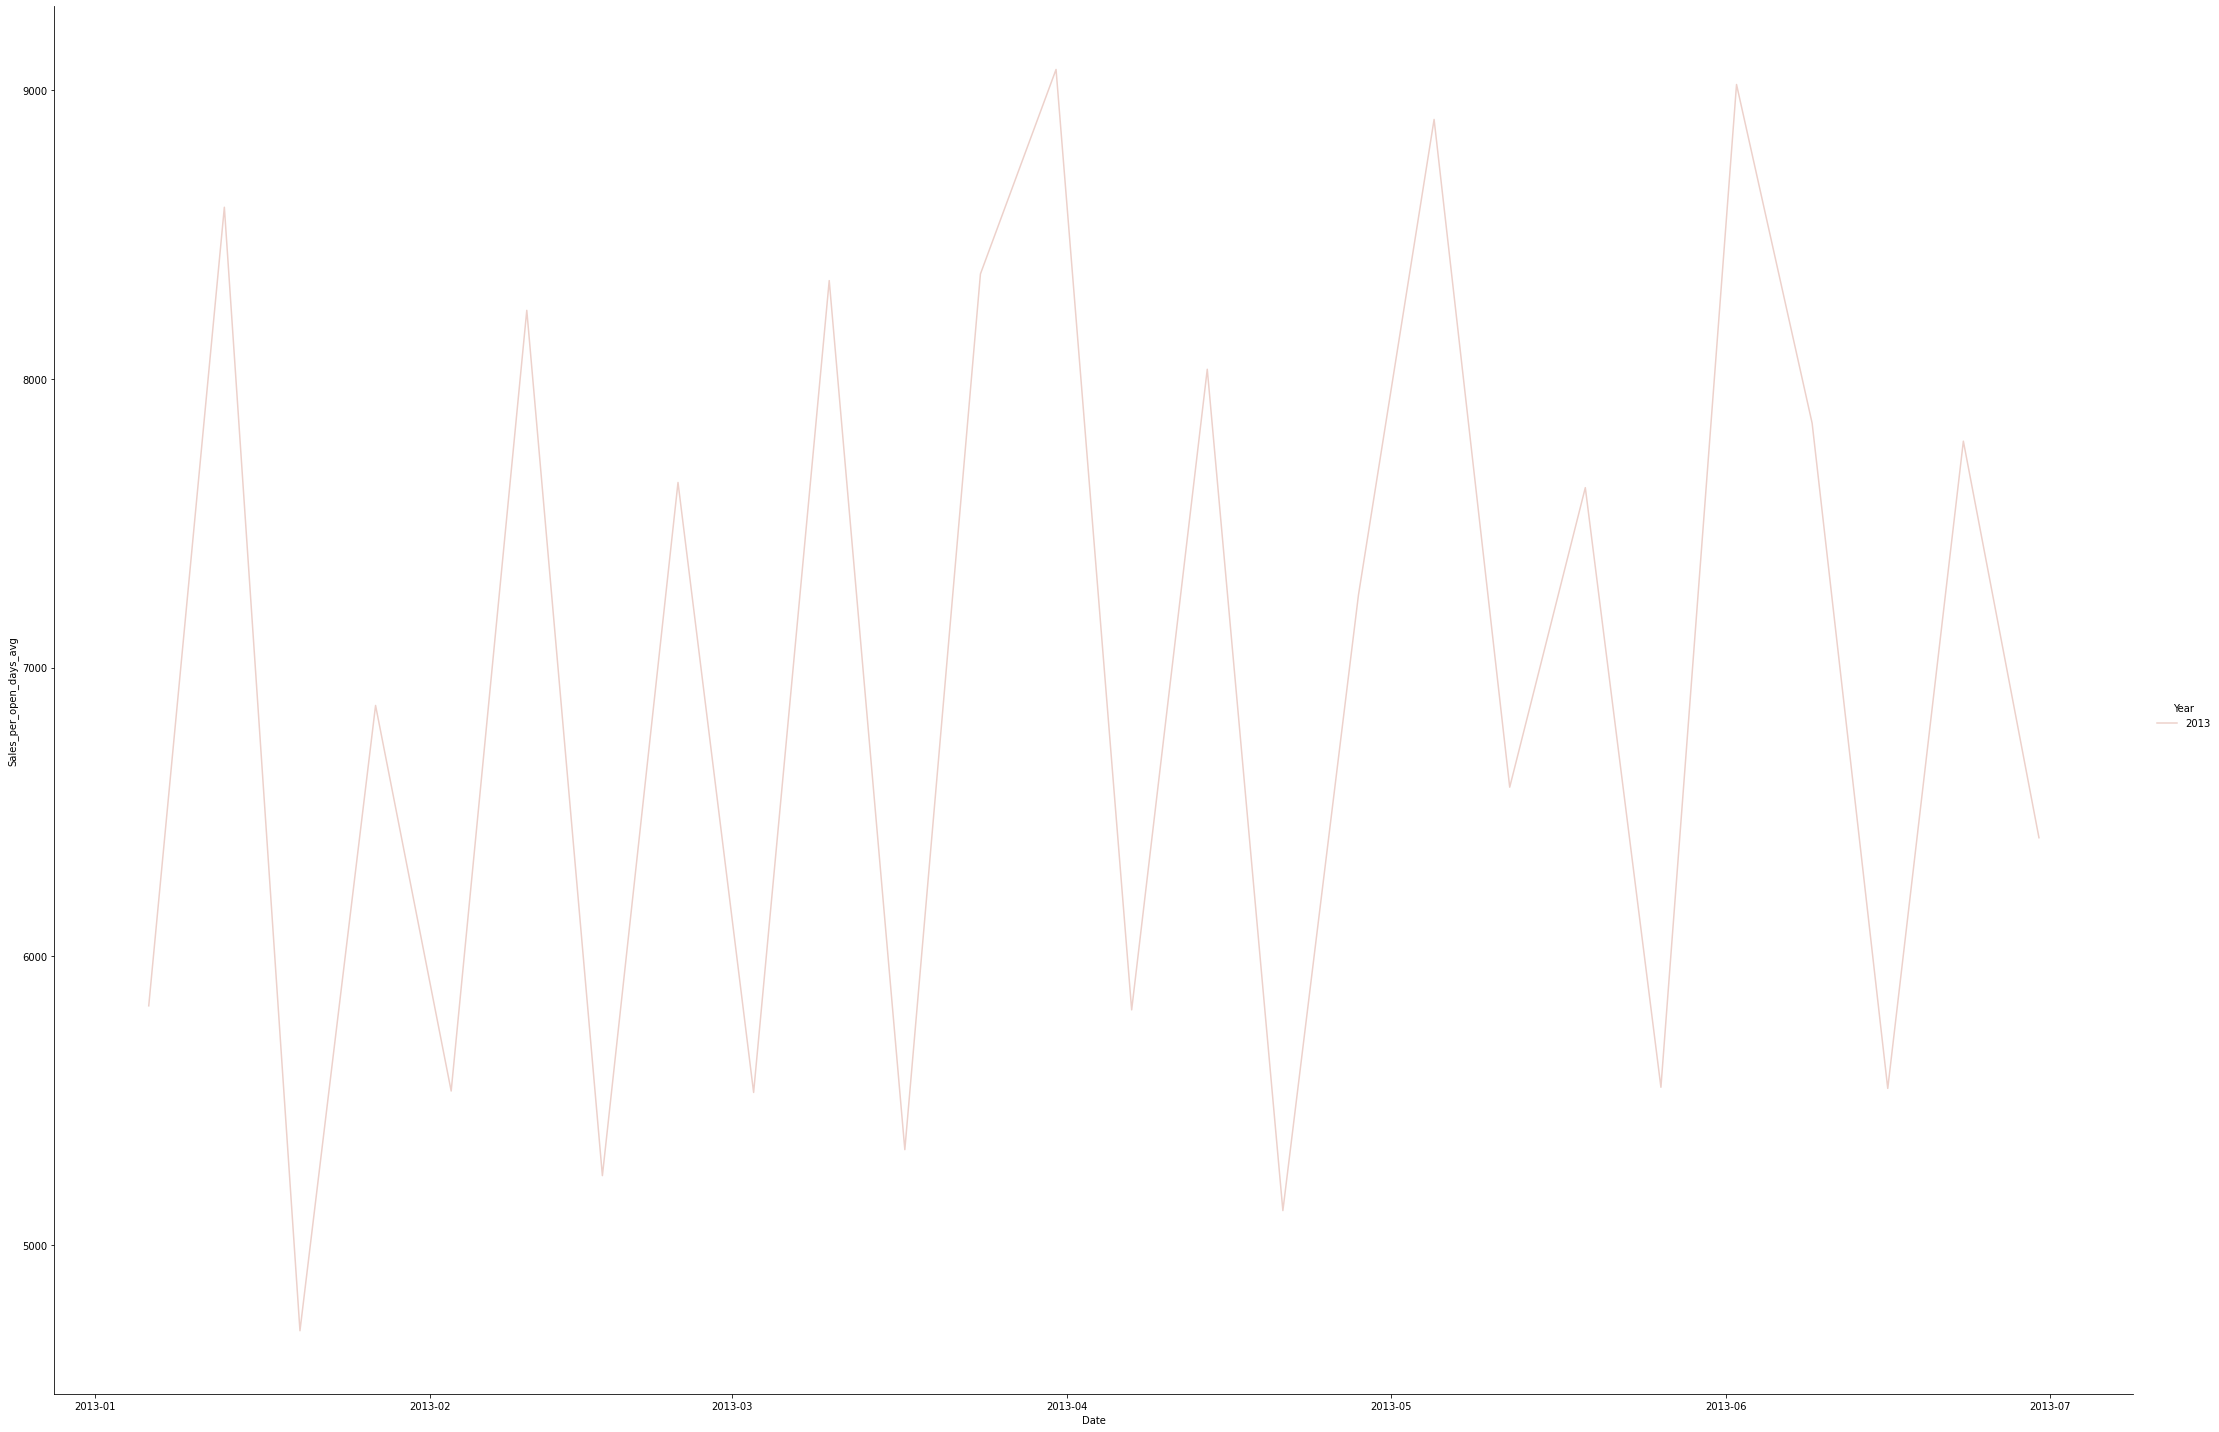

In [64]:
from pandas.plotting import lag_plot
import seaborn as sns
import matplotlib.pyplot as plt

# Grouped by Store
df_train_stores = df_train.groupby(by=['Store'])
#df_train_stores.Date.max()
#df_train_stores.Date.min()
df_X = df_train_stores.get_group(3).set_index('Date')
sales_zero_idx = df_X[df_X['Sales'] == 0].index
df_X = df_X.drop(sales_zero_idx)
#df_X['2015-01-01':'2015-02-01'].tail(10)
#df_X.head(10)

def avg_sales_per_period(df: DataFrame) -> pd.Series:
    df_copy = df.copy()
    s_tmp: pd.Series = df['Sales'] / df['Open']
    df_copy['Sales_per_open_days_avg'] = s_tmp.astype('int')
    return df_copy


# resample/groupby WEEK
df_weekly_sum: DataFrame = df_X.resample("W").sum()
df_weekly_sum['Year'] = df_weekly_sum.index.year
df_weekly_sum['Week'] = df_weekly_sum.index.week
#df_weekly_sum['Week'] = df_weekly_sum.index.map(lambda week: week.strftime('%m-%d'))
df_weekly_sum = avg_sales_per_period(df_weekly_sum)
df_weekly_sum.head(5)

sns.relplot(data=df_weekly_sum.loc['2013-01':'2013-06'].reset_index(),
            x='Date',
            y='Sales_per_open_days_avg',
            hue='Year',
            kind='line',
            markers=True,
            #palette=sns.color_palette('tab10'),
            height=20.0, aspect=1.5)
plt.show()



# Auto-regression | Analysis

Here we try to use auto-regressive analysis to see whether there is a auto-correlation between defined lags

## Weekly lags -> Forecast weekly sales

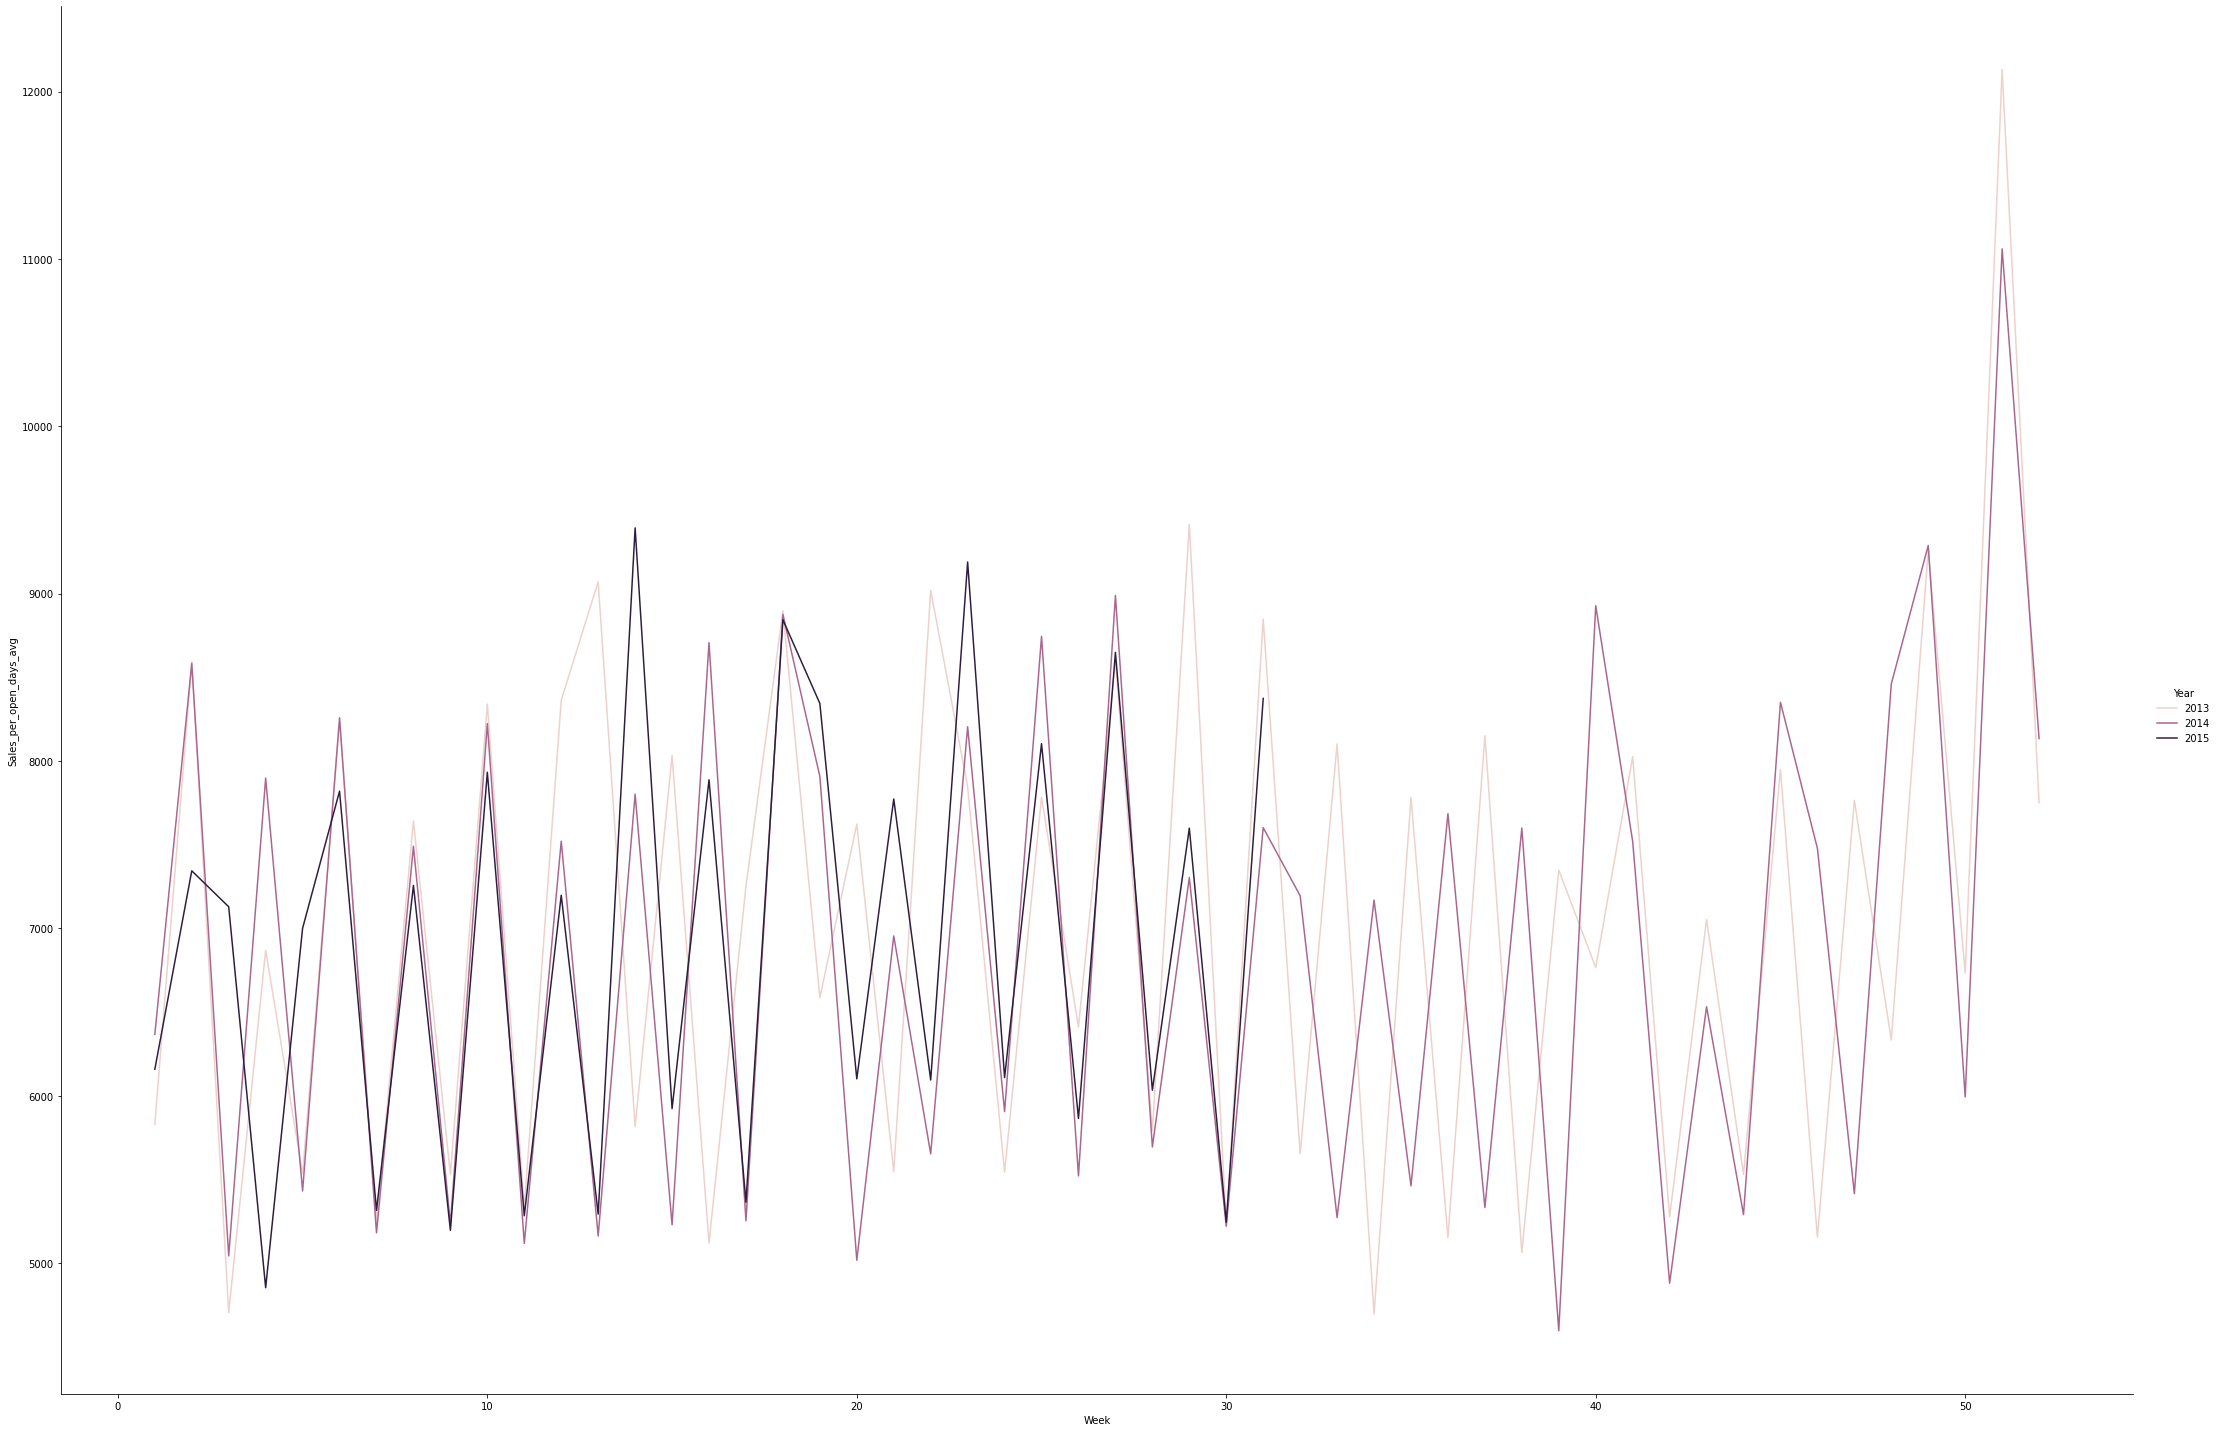

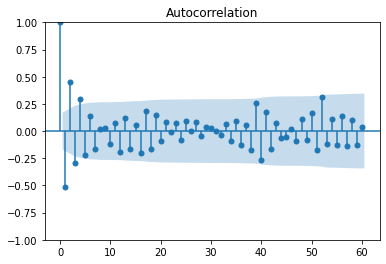

In [65]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt

g = sns.relplot(data=df_weekly_sum.loc['2013-01':],
            x='Week',
            y='Sales_per_open_days_avg',
            hue='Year',
            kind='line',
            markers=True,
            height=20.0, aspect=1.5)
plt.show()

#stattools.acf(df_weekly_sum['Sales_per_open_days_avg'], nlags=8)

f = plot_acf(df_weekly_sum['Sales_per_open_days_avg'], lags=60)
plt.show()

# plot = lag_plot(series=df_weekly_sum['Sales_per_open_days_avg'], lag=2)
# plt.show()

### Weekly | Time series decomposition in Trend, Seasonal and Residuals
Decompose to extract trend cycle for better ACF with the Seasonal component with yt = S+T+R cause we have a additive decompoition in _classical decomposition_ cause the changes in trend and seasonality are linear changing (trend) and constant (seasonality period).

1. [General Time series decomposition](https://otexts.com/fpp3/classical-decomposition.html)
2. [Very short intro to STL](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality)

#### Additive classical decomposition
yt = St + Tt + Rt using MA (moving average). See the yearly same pattern of _S_ component.

1. [Additive classical decomposition with examples in python statsmodel](https://otexts.com/fpp3/classical-decomposition.html#additive-decomposition)

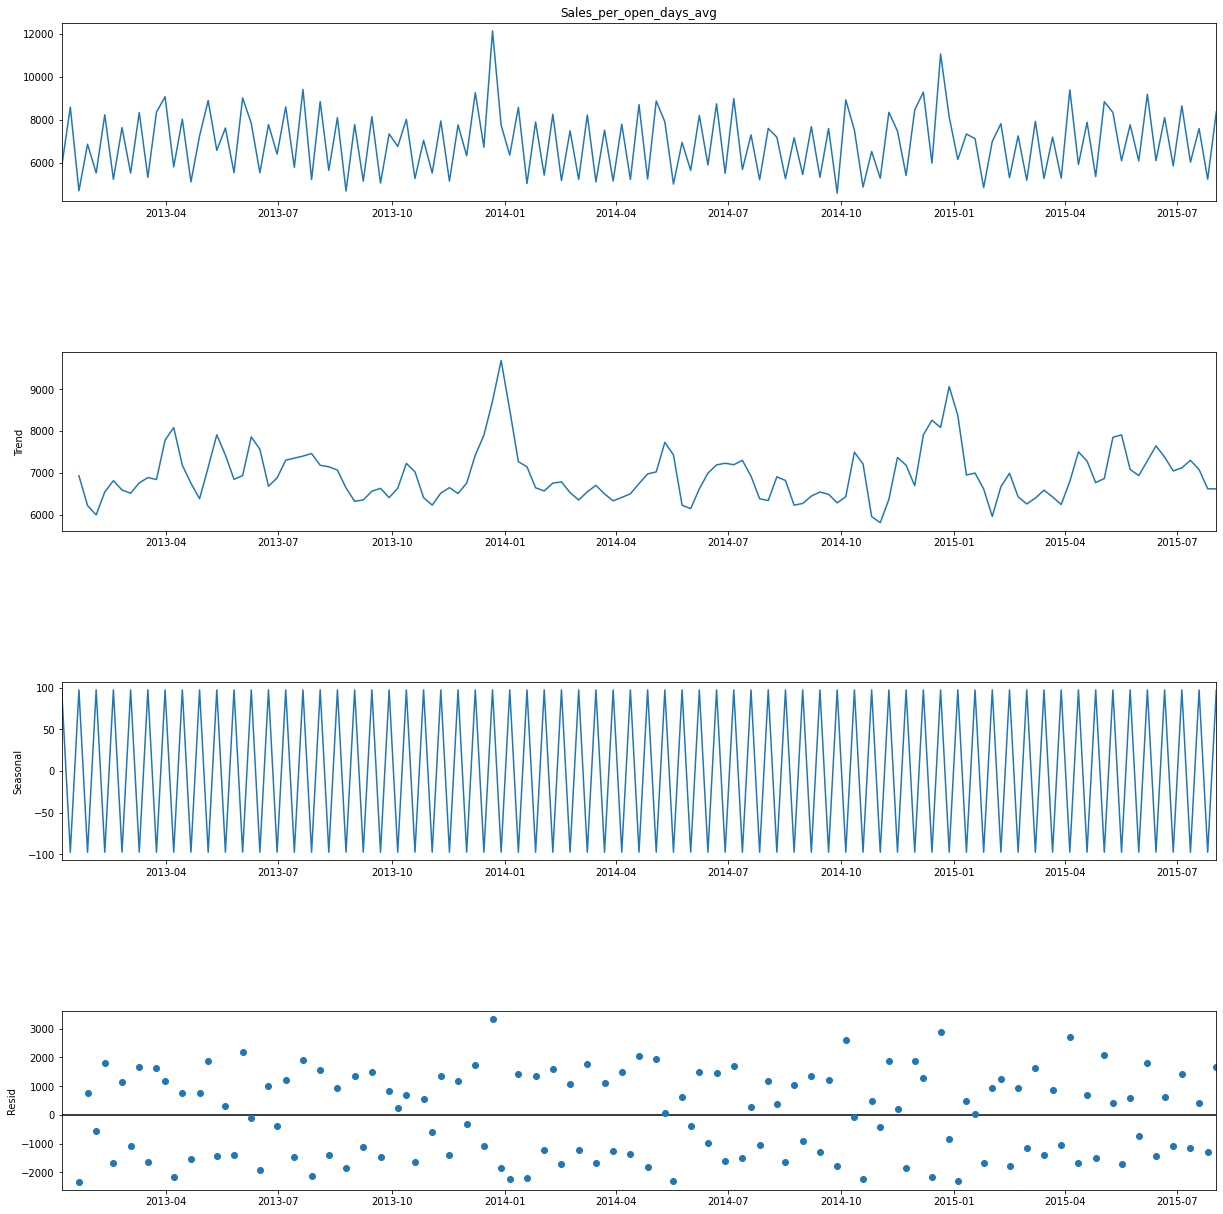

'MEAN(R): -3.0713195386703'

'VAR(R) : 2156683.7929428914'

In [66]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

stl_decomp_result: DecomposeResult = seasonal_decompose(df_weekly_sum['Sales_per_open_days_avg'], model="additive", period=2, two_sided=False, extrapolate_trend=0)

f: plt.Figure = stl_decomp_result.plot()
f.set_size_inches(w=20, h=20)
plt.show()

# check

# residuals are white noise now?
"MEAN(R): {}".format(stl_decomp_result.resid.mean())
"VAR(R) : {}".format(stl_decomp_result.resid.var())
# formal autocorrelation test of residuals -> small p-value means each lag correlation value is relative small
#acorr_ljungbox(stl_decomp_result.resid, lags=13)

#### STL decomposition

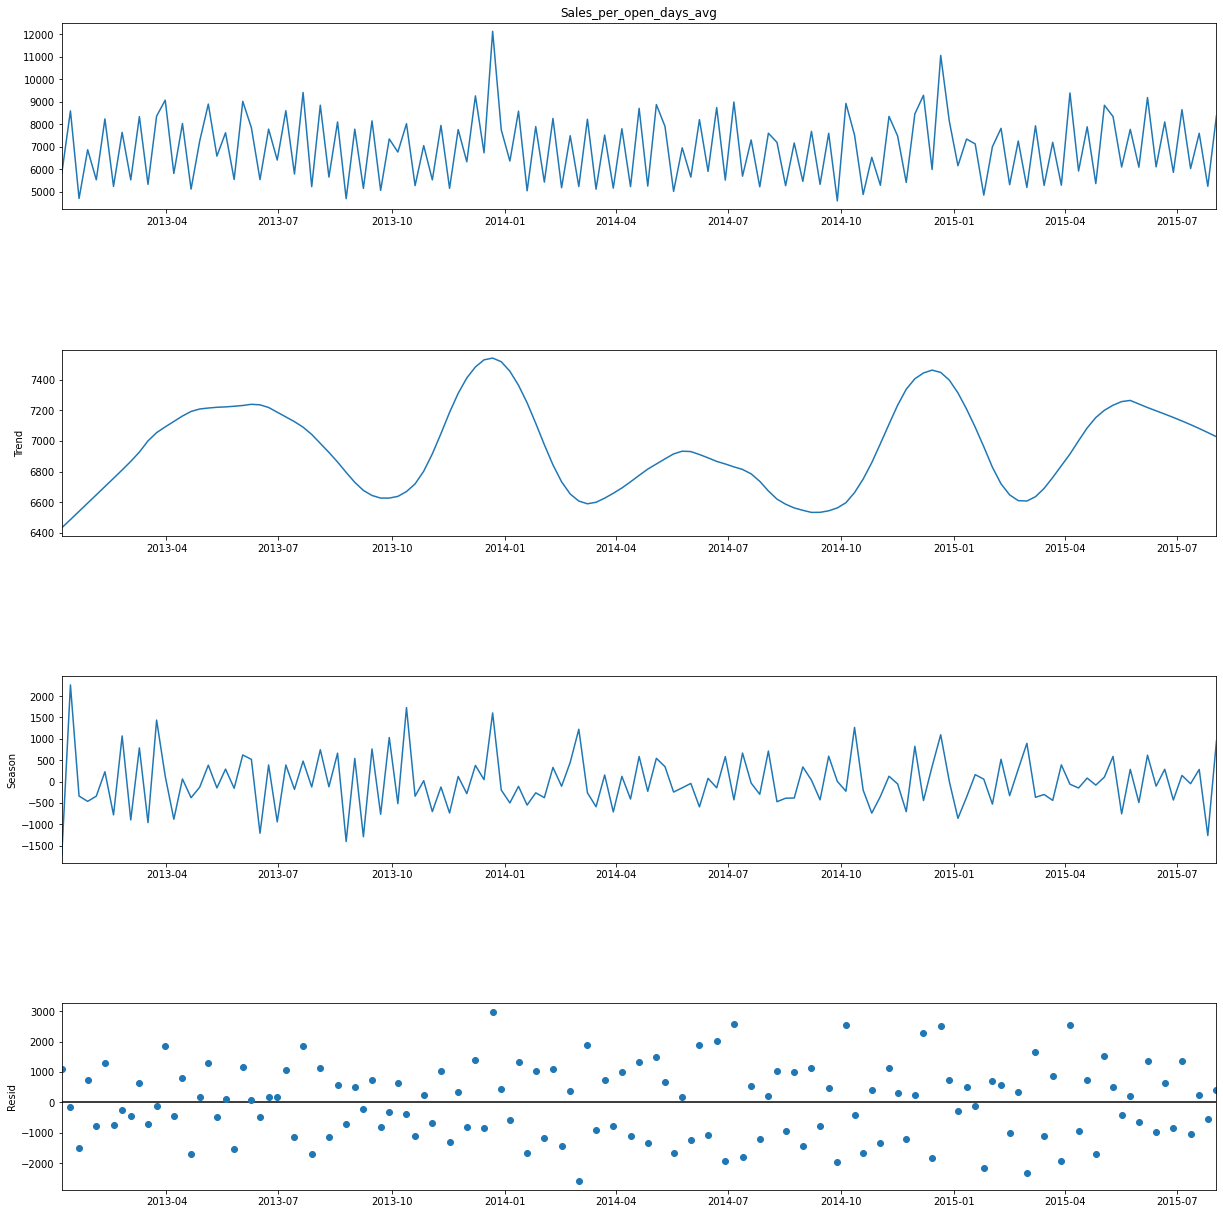

In [67]:
from statsmodels.tsa._stl import STL
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

stl_decomp_result: DecomposeResult = STL(df_weekly_sum['Sales_per_open_days_avg'], period=10).fit()

f: plt.Figure = stl_decomp_result.plot()
f.set_size_inches(w=20, h=20)
plt.show()

# Auto-regression | Forecast sales with non-seasonal ARIMA

In [68]:
from statsmodels.tsa.ar_model import AutoReg, AutoRegResults
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

X = df_weekly_sum['Sales']

for X_train_idx, X_test_idx in TimeSeriesSplit(n_splits=5, test_size=2).split(X):
    y_train = X.iloc[X_train_idx]
    regressor: AutoReg = AutoReg(endog=y_train, lags=[12])
    model_fit = regressor.fit()
    print('Coefficients: %s' % model_fit.params)
    result: AutoRegResults = model_fit.predict(start=20, end=22)



ImportError: cannot import name 'call_cached_func' from 'statsmodels.compat.pandas' (/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/compat/pandas.py)